### Download data

In [2]:
import urllib
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sbs

%matplotlib inline

### Network descriptive analysis.

This is the interaction network of online users, which contains about 10,000 nodes and 25,000 undirected edges.

In [3]:
url = "https://dl.dropboxusercontent.com/s/q9geru5vtmz5b55/vk.adjlist?dl=1"
with urllib.request.urlopen(url) as f:
    data = f.read().decode('utf-8')
with open('vk.adjlist', 'w') as f:
    f.write(data) 
    
G = nx.read_adjlist('vk.adjlist')

print("Graph is created!!")    
print("Number of nodes: {:,d}".format(len(G.nodes())))
print("Number of edges: {:,d}".format(G.size()))

Graph is created!!
Number of nodes: 2,113
Number of edges: 25,737


Distribution of node degrees aligns with the power-law distribution: cCDF in log-log scales is almost straight line.

Text(0.5, 1.0, 'cCDF in log-log scale')

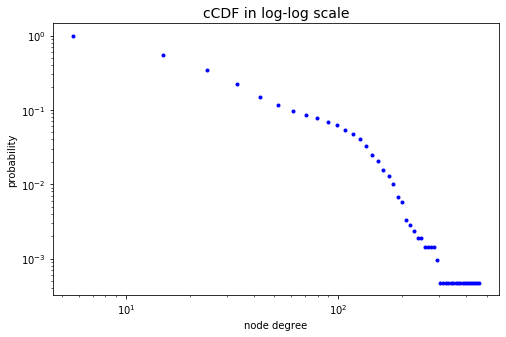

In [13]:
degrs = G.degree()
yh, binEdges = np.histogram(list(dict(degrs).values()), bins=50)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
plt.figure(figsize = (8,5))
plt.loglog(bincenters, np.cumsum(yh[::-1], dtype=float)[::-1] / np.cumsum(yh)[-1], 'b.')
plt.ylabel('probability')
plt.xlabel('node degree')
plt.title("cCDF in log-log scale", fontsize = 14)    

There is a single connected component.

In [15]:
print('Number of connected components: {:,d}'.format(nx.number_connected_components(G)))
largestCC = sorted(nx.connected_components(G), key = len, reverse=True)[0]
GraphLargestCC = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
print('Largest CC size: {:,d} nodes'.format(len(largestCC)))

Number of connected components: 1
Largest CC size: 2,113 nodes


In [17]:
# Reorder nodes to better visualize tight connections
reordered_nodes = list(nx.utils.reverse_cuthill_mckee_ordering(G))
adj_matrix = nx.to_scipy_sparse_matrix(G, nodelist = reordered_nodes)
degrs = np.asarray(adj_matrix.sum(axis=0))[0]
n = adj_matrix.shape[0]

Text(0.5, 1.1, 'Adjacency matrix')

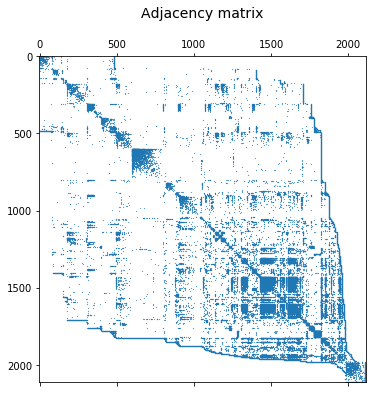

In [18]:
# Plot adjacency matrix with reordered lines
ax = plt.figure(figsize=(6, 6))
plt.spy(adj_matrix, markersize=0.2)
plt.title("Adjacency matrix", fontsize = 14, y = 1.1)

### Main task.

**Goal:** Maximize influence and profit from the campaign.  

Reasonable assumption: if campaign has any positive effect, then the profit positively depends on influence until some optimal value. After that value, the increase in influence reduces profit, because the **marginal effect** or **marginal profit** becomes negative. In other words, the agents become "worse" and at some point it will not worth attracting them at all, as we attract the best ones at first.

More formally, the profit function might be **concave** and it could be possible to find its optimal value.

Simple example is illustrated below when the advertising campaign has positive effect: 

Text(0.5, 1.0, 'Profit as a function of influence')

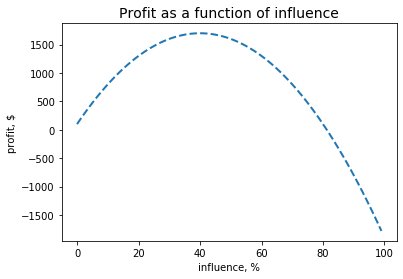

In [19]:
# Plot simple concave function
X = np.arange(0, 100, 1)
Y = -(X-30)**2 + 1000 + 20*X
plt.plot(X, Y, '--',lw = 2); plt.xlabel("influence, %"); plt.ylabel("profit, $"); 
plt.title("Profit as a function of influence", fontsize = 14)

It is worth noticing, that under given pricing conditions ($250 \$$ revenue and $300 \$$ cost) and network structure, the campaign might be unprofitable at all. So the profit would be just decreasing function of influence.

### Attempt #1: random initialization. 

To compare different strategies, we need baseline, which indicates the worst case scenario.  


For example, let's attract **random people** for the marketing campaign.  

Herein after we have to pick **threshold**, which will be criterion of node's activation. For simplicity, let's assume that the threshold is 1/4 which means that if more than one fourth of node's neighbors are activated, the node also becomes activated. The threshold is actually dependent on any particular business task.  

Several additional assumption can be made to make computations faster:

* Maximum number of agents is 300. It seems to be reasonable to attract 2-3% of people as advertising agents.  
* Number of iterations for each agent equals 3. This value also highly depends on particular business task and might be interpreted as the amount of contacts, which are made by any new "infected" node.

In [20]:
theta = 1/4
agents_num = 300
interval = np.arange(0, agents_num, 5)

In [21]:
# Function to calculate influance propagation
def InfluenceProp(A, initActive, theta, num_iter = 3):
    deg = A.sum(axis=0)
    resActive = initActive.copy()
    i = 0
    while i < num_iter:
        i += 1
        inactiveId = np.where(resActive == 0)[0]    
        idx = A[np.ix_(resActive==1, resActive==0)].sum(axis=0) / deg[0, resActive==0] > theta
        idx = np.squeeze(np.asarray(idx))
        if np.any(idx):
            resActive[inactiveId[idx]] = 1
        else:
            return resActive
    return resActive

In [22]:
# Function to calculate profit and influence for any given number of agents
def SimulateRes(agents_num, idxs):
    influence = []
    profit = []
    i = 0
    idx = []
    initActive = np.zeros((n,), dtype=bool)
    while i < agents_num:
        initActive[idxs[:i]] = 1
        initActive = InfluenceProp(adj_matrix, initActive, theta)
        infl = initActive.sum()
        influence.append(infl)
        cost = 300 * degrs[idxs[:i]].sum()
        rev = 250 * initActive.sum()
        prof = rev - cost
        profit.append(prof)
        i+= 5
        marginal_profit = np.array(profit[1:]) - np.array(profit[:-1])
    return influence, profit, marginal_profit

In [23]:
# Generate random integers
idxs_rand = np.random.randint(0, n, 1000)

In [24]:
# Calculate results in case of random initialization
influence_rand, profit_rand, marginal_rand = SimulateRes(agents_num, idxs = idxs_rand)

In [25]:
# Function to plot profit, influence and marginal profit
def plot_results(influence, profit, marginal_profit, agents_num):
    plt.figure(figsize = (16, 5))
    plt.subplot(1,3,1)
    plt.plot(influence, profit, lw = 3); 
    plt.xlabel("influence, people"); 
    plt.ylabel("profit, $"); 
    plt.title("Profit", fontsize = 14)

    plt.subplot(1,3,2)
    plt.plot(range(0, agents_num, 5), influence, 'g', lw = 3); 
    plt.xlabel("number of agents, people"); 
    plt.ylabel("influence, people"); 
    plt.title("Influence", fontsize = 14)
    
    plt.subplot(1,3,3)
    plt.bar(range(1, agents_num-5, 5), marginal_profit, color = 'r') 
    plt.xlabel("influence, people"); 
    plt.ylabel("marginal profit, $"); 
    plt.title("Marginal profit", fontsize = 14)

    plt.tight_layout()

Obviously, random initialization is **not effective** at all (at least for this network structure).  
* Profit is almost decreasing function of influence and negative everywhere.
* Influence itself is the straight line, which means that generally each new node's activation activates this new node only, but not it's neighbors.
* Marginal profit has few positive values, which are successful random "shots". But still in general the marginal profit is highly negative. 

Text(0.5, 1.05, 'Random initialization')

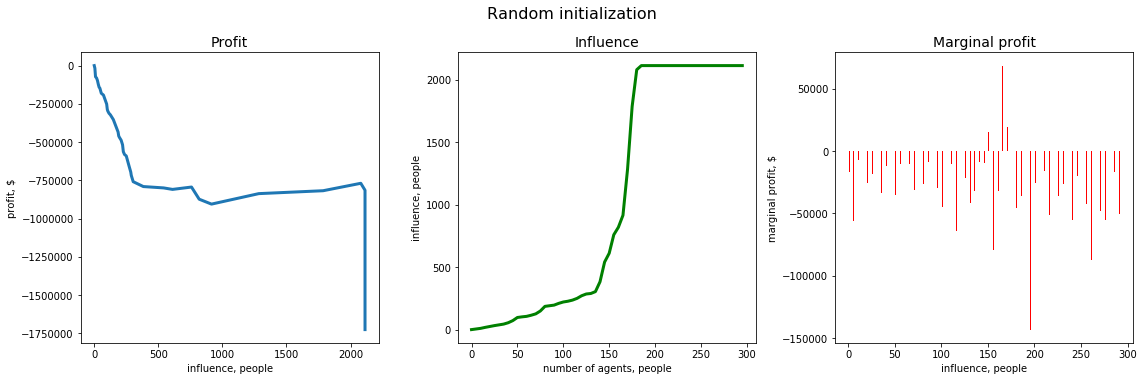

In [26]:
plot_results(influence_rand, profit_rand, marginal_rand, agents_num)
plt.suptitle("Random initialization", fontsize=16, y = 1.05)

### Attempt #2: attract nodes with maximum node degrees. 

The better but still naive approach is just to pay the agents who have the maximum number of connections. Naive, because we might pay the person much money for his or her friends, but those friends might still be unactivated.  
For these purpose we need to sort the nodes according to their degree values and choose K first.

In [27]:
# Sort the nodes according to their degree values
idxs_degr = degrs.argsort()[-1::-1]

In [28]:
influence_degr, profit_degr, marginal_degr = SimulateRes(agents_num, idxs = idxs_degr)

Text(0.5, 1.05, 'Node degrees naive approach')

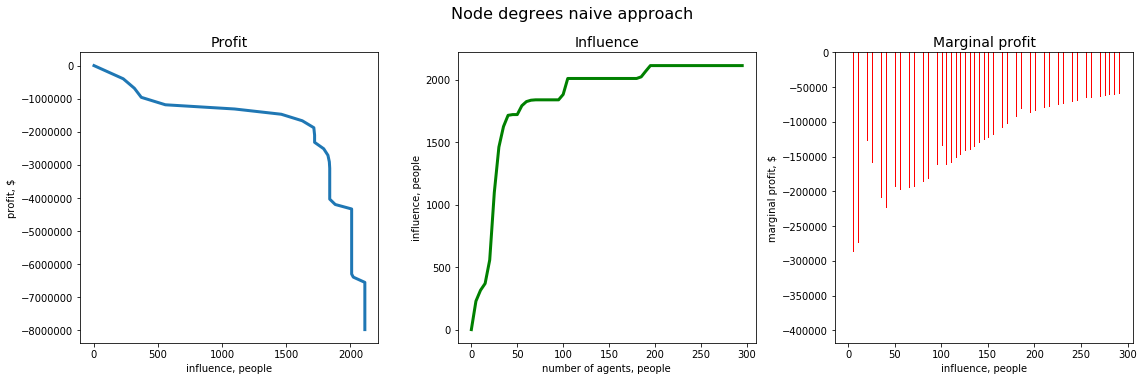

In [29]:
plot_results(influence_degr, profit_degr, marginal_degr, agents_num)
plt.suptitle("Node degrees naive approach", fontsize=16, y = 1.05)

### Attempt #3: utilize centrality measures

Why do not we use another centrality measures, besides of node degrees? 

Several commonly-used centrality measures:

* Closeness centrality
* Betweenness centrality
* Pagerank values
* Eigenvector centrality

Closeness centrality:

In [30]:
centr_clsn = nx.closeness_centrality(G)
centr_clsn = np.array([centr_clsn[k] for k in reordered_nodes])
idxs_clsn = centr_clsn.argsort()[-1::-1]

In [31]:
influence_clsn, profit_clsn, marginal_clsn = SimulateRes(agents_num, idxs = idxs_clsn)

Betweenness centrality:

In [32]:
centr_bwn = nx.betweenness_centrality(G)
centr_bwn = np.array([centr_bwn[k] for k in reordered_nodes])
idxs_bwn = centr_bwn.argsort()[-1::-1]

In [33]:
influence_bwn, profit_bwn, marginal_bwn = SimulateRes(agents_num, idxs = idxs_bwn)

Pagerank:

In [34]:
centr_pagerank = nx.pagerank_scipy(G, max_iter=1000)
centr_pagerank = np.array([centr_pagerank[k] for k in reordered_nodes])
idxs_pagerank = centr_pagerank.argsort()[-1::-1]

In [35]:
influence_pagerank, profit_pagerank, marginal_pagerank = SimulateRes(agents_num, idxs = idxs_pagerank)

Eigenvector centrality:

In [36]:
centr_eig = nx.eigenvector_centrality_numpy(G)
centr_eig = np.array([centr_eig[k] for k in reordered_nodes])
idxs_eig = centr_eig.argsort()[-1::-1]

In [37]:
influence_eig, profit_eig, marginal_eig = SimulateRes(agents_num, idxs = idxs_eig)

Plot results of all metrics.  
Pagerank value is the best criterion to initialize nodes. Betweenness centrality is slightly worse, whereas closeness and eigenvector centralities do not give good results. 

Text(0.5, 1, 'Influence')

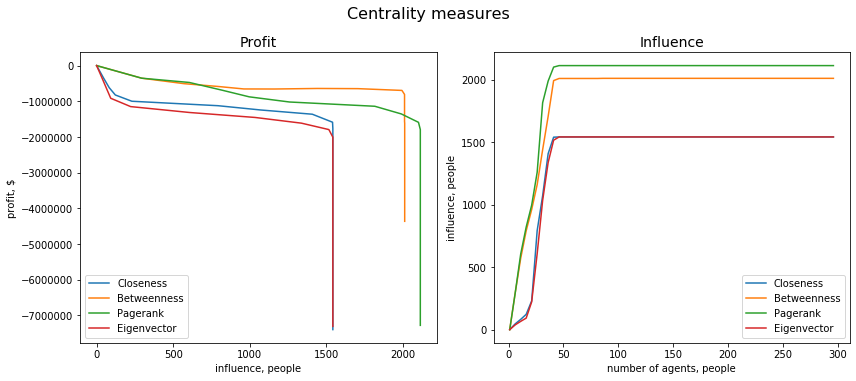

In [38]:
metrics = ['Closeness','Betweenness', 'Pagerank', 'Eigenvector']

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1); plt.xlabel("influence, people"); plt.ylabel("profit, $"); 
plt.plot(influence_clsn, profit_clsn)
plt.plot(influence_bwn, profit_bwn)
plt.plot(influence_pagerank, profit_pagerank)
plt.plot(influence_eig, profit_eig)
plt.legend(metrics, loc = 'best')
plt.title("Profit", fontsize = 14)

plt.subplot(1,2,2); plt.xlabel("number of agents, people"); plt.ylabel("influence, people"); 
plt.plot(range(1, agents_num, 5), influence_clsn)
plt.plot(range(1, agents_num, 5), influence_bwn)
plt.plot(range(1, agents_num, 5), influence_pagerank)
plt.plot(range(1, agents_num, 5), influence_eig)
plt.tight_layout()
plt.legend(metrics, loc = 'best')
plt.suptitle("Centrality measures", fontsize=16, y = 1.05)
plt.title("Influence", fontsize = 14)

In [39]:
print(max(profit_pagerank), max(profit_degr))
print(max(influence_pagerank), max(influence_degr))

0 0
2113 2113


**Pagerank allows us to easily increase profit from the campaign by 3.5 times and total influence by 15% in comparison with the conventional node degree criterion.**
<br>
<br>
Nevertheless, Pagerank initialization still requires initial investments until marginal profit becomes positive.

Text(0.5, 1.0, 'Marginal profit')

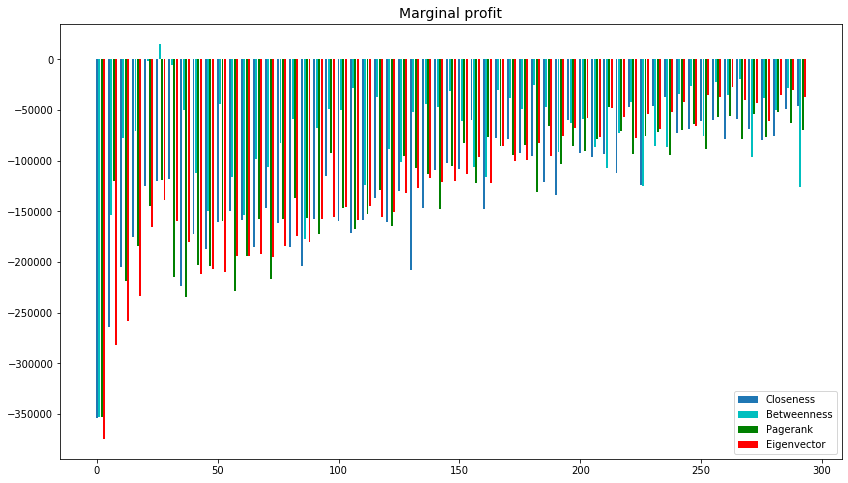

In [40]:
plt.figure(figsize=(14, 8))
plt.bar(interval[:-1], marginal_clsn); 
plt.bar(interval[:-1]+1, marginal_bwn, color = 'c'); 
plt.bar(interval[:-1]+2, marginal_pagerank, color = 'g'); 
plt.bar(interval[:-1]+3, marginal_eig, color = 'r')
plt.legend(metrics, loc = 'best')
plt.title("Marginal profit", fontsize = 14)

Greedy optimization, though being simplified, has shown substantial advantage over other initialization methods for profit optimization goal.

Text(0.5, 1, 'Influence')

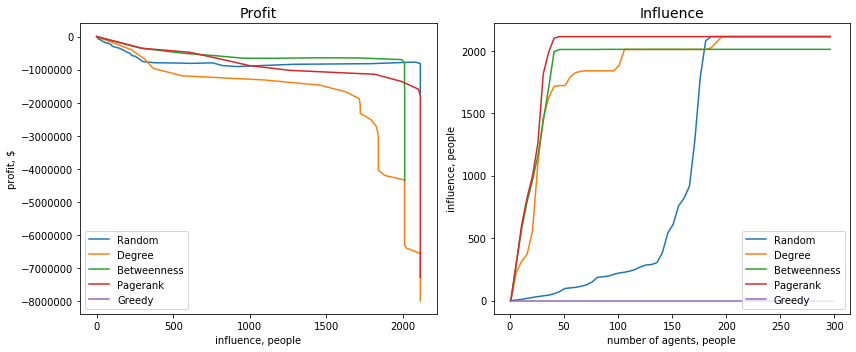

In [46]:
metrics = ['Random', 'Degree', 'Betweenness', 'Pagerank', 'Greedy']

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1); plt.xlabel("influence, people"); plt.ylabel("profit, $"); 
plt.plot(influence_rand, profit_rand)
plt.plot(influence_degr, profit_degr)
plt.plot(influence_bwn, profit_bwn)
plt.plot(influence_pagerank, profit_pagerank)
plt.plot(influence_greedy, profit_greedy)
plt.legend(metrics, loc = 'best')
plt.title("Profit", fontsize = 14)

plt.subplot(1,2,2); plt.xlabel("number of agents, people"); plt.ylabel("influence, people"); 
plt.plot(range(1, agents_num, 5), influence_rand)
plt.plot(range(1, agents_num, 5), influence_degr)
plt.plot(range(1, agents_num, 5), influence_bwn)
plt.plot(range(1, agents_num, 5), influence_pagerank)
plt.tight_layout()
plt.legend(metrics, loc = 'lower right')
plt.title("Influence", fontsize = 14)

However, profit maximization does not mean influence maximization. It is shown above that greedy optimization in our case works little bit worse in terms of influence or auditory size.